# Market Basket Analysis

## Importing Libraries

In [34]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

## Data Collection

In [45]:
df = pd.read_csv('C:/Users/kumar/OneDrive/Desktop/Machine Learning Project/datasets/groceries market basket analysis.csv')
df.shape

(38765, 3)

In [7]:
df.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [8]:
df.describe()

,Member_number
count,38765.000000
mean,3003.641868
std,1153.611031
min,1000.000000
25%,2002.000000
50%,3005.000000
75%,4007.000000
max,5000.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


## Data Preprocessing 

In [36]:
# checking for missing values
df.isnull().sum()

Member_number      0
Date               0
itemDescription    0
dtype: int64

In [37]:
# checking for duplicate values
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [12]:
df.shape
# we removed all the duplicate values here 

(38006, 3)

In [46]:
#  Transaction Formation
transactions = (
    df
    .groupby(["Member_number", "Date"])["itemDescription"]
    .apply(list)
    .tolist()
)

# print first 5 complete transactions
transactions[:5]


[['sausage', 'whole milk', 'semi-finished bread', 'yogurt'],
 ['whole milk', 'pastry', 'salty snack'],
 ['canned beer', 'misc. beverages'],
 ['sausage', 'hygiene articles'],
 ['soda', 'pickled vegetables']]

In [14]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [47]:
# One hot encoding the transactions
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
encoded = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(encoded, columns=te.columns_)

## Training

In [48]:
# Model Training (Frequent Itemset Generation)
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(
    df_encoded,
    min_support=0.005,  # Further reduced to 0.5% to generate more itemsets and rules
    use_colnames=True
)


In [44]:
# Check frequent itemsets
print("Number of frequent itemsets:", len(frequent_itemsets))
print("\nFrequent itemsets shape:", frequent_itemsets.shape)
print("\nFrequent itemsets details:")
print(frequent_itemsets)
print("\nItemsets with more than 1 item (needed for rules):")
frequent_itemsets_with_multiple = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) > 1)]
print(f"Count: {len(frequent_itemsets_with_multiple)}")
print(frequent_itemsets_with_multiple)

Number of frequent itemsets: 69

Frequent itemsets shape: (69, 2)

Frequent itemsets details:
     support                        itemsets
0   0.021386                      (UHT-milk)
1   0.033950                          (beef)
2   0.021787                       (berries)
3   0.016574                     (beverages)
4   0.045312                  (bottled beer)
..       ...                             ...
64  0.010559  (rolls/buns, other vegetables)
65  0.014837  (whole milk, other vegetables)
66  0.013968        (rolls/buns, whole milk)
67  0.011629              (whole milk, soda)
68  0.011161            (whole milk, yogurt)

[69 rows x 2 columns]

Itemsets with more than 1 item (needed for rules):
Count: 5
     support                        itemsets
64  0.010559  (rolls/buns, other vegetables)
65  0.014837  (whole milk, other vegetables)
66  0.013968        (rolls/buns, whole milk)
67  0.011629              (whole milk, soda)
68  0.011161            (whole milk, yogurt)


In [60]:
# Rule Generation

from mlxtend.frequent_patterns import association_rules

# Try without minimum threshold first
try:
    rules = association_rules(
        frequent_itemsets,
        metric="confidence",
        min_threshold=0.01
    )
    print(f"Rules generated with confidence>=0.01: {len(rules)}")
except Exception as e:
    print(f"Error generating rules with confidence: {e}")
    
# If that doesn't work, try with lift
if len(rules) == 0:
    try:
        rules = association_rules(
            frequent_itemsets,
            metric="lift",
            min_threshold=1
        )
        print(f"Rules generated with lift>=1: {len(rules)}")
    except Exception as e:
        print(f"Error generating rules with lift: {e}")

Rules generated with confidence>=0.01: 74


In [58]:
# Check rules before filtering
print("Total rules generated: ", len(rules))
print("\nFirst 10 rules sorted by confidence:")
print(rules[["antecedents", "consequents", "confidence", "lift"]].head(10))

print("\nConfidence statistics:")
print(rules['confidence'].describe())
print("\nLift statistics:")
print(rules['lift'].describe())
print(f"\nMin confidence: {rules['confidence'].min()}")
print(f"Max confidence: {rules['confidence'].max()}")
print(f"Min lift: {rules['lift'].min()}")
print(f"Max lift: {rules['lift'].max()}")

Total rules generated:  0

First 10 rules sorted by confidence:
Empty DataFrame
Columns: [antecedents, consequents, confidence, lift]
Index: []

Confidence statistics:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: confidence, dtype: float64

Lift statistics:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: lift, dtype: float64

Min confidence: nan
Max confidence: nan
Min lift: nan
Max lift: nan


In [ ]:
# Rule Evaluation and Filtering
rules = rules.sort_values(
    by=["confidence", "lift"],
    ascending=False
)

# Filter with thresholds appropriate for this dataset
# Confidence: min 0.05 (5%)  - rules that are true at least 5% of the time
# Lift: min 0.8 - rules that don't perform worse than random (can be <1 for this dataset)
rules = rules[
    (rules["confidence"] >= 0.05) &
    (rules["lift"] >= 0.8)
]

print(f"Rules after filtering (confidence >= 0.05, lift >= 0.8): {len(rules)}")


Rules after filtering (confidence >= 0.05, lift >= 0.8): 32


In [61]:
# Check rules BEFORE filtering
print("=== BEFORE FILTERING ===")
print(f"Total rules: {len(rules)}")
print(f"\nConfidence range: {rules['confidence'].min():.4f} to {rules['confidence'].max():.4f}")
print(f"Lift range: {rules['lift'].min():.4f} to {rules['lift'].max():.4f}")
print("\nTop 10 rules by confidence:")
print(rules.nlargest(10, 'confidence')[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

=== BEFORE FILTERING ===
Total rules: 74

Confidence range: 0.0317 to 0.1578
Lift range: 0.6215 to 1.1161

Top 10 rules by confidence:
        antecedents         consequents   support  confidence      lift
1    (bottled beer)        (whole milk)  0.007151    0.157817  0.999330
56        (sausage)        (whole milk)  0.008955    0.148394  0.939663
17     (newspapers)        (whole milk)  0.005614    0.144330  0.913926
11  (domestic eggs)        (whole milk)  0.005280    0.142342  0.901341
15    (frankfurter)        (whole milk)  0.005280    0.139823  0.885388
12    (frankfurter)  (other vegetables)  0.005146    0.136283  1.116150
37           (pork)        (whole milk)  0.005012    0.135135  0.855703
35      (pip fruit)        (whole milk)  0.006616    0.134877  0.854071
8    (citrus fruit)        (whole milk)  0.007151    0.134591  0.852259
61  (shopping bags)        (whole milk)  0.006349    0.133427  0.844887


In [65]:
# Knowledge Extraction
final_rules = rules[["antecedents", "consequents", "support", "confidence", "lift"]]
print(final_rules)


           antecedents         consequents   support  confidence      lift
1       (bottled beer)        (whole milk)  0.007151    0.157817  0.999330
56           (sausage)        (whole milk)  0.008955    0.148394  0.939663
17        (newspapers)        (whole milk)  0.005614    0.144330  0.913926
11     (domestic eggs)        (whole milk)  0.005280    0.142342  0.901341
15       (frankfurter)        (whole milk)  0.005280    0.139823  0.885388
12       (frankfurter)  (other vegetables)  0.005146    0.136283  1.116150
37              (pork)        (whole milk)  0.005012    0.135135  0.855703
35         (pip fruit)        (whole milk)  0.006616    0.134877  0.854071
8       (citrus fruit)        (whole milk)  0.007151    0.134591  0.852259
61     (shopping bags)        (whole milk)  0.006349    0.133427  0.844887
73            (yogurt)        (whole milk)  0.011161    0.129961  0.822940
7        (canned beer)        (whole milk)  0.006015    0.128205  0.811821
46        (rolls/buns)   

In [66]:
print(frequent_itemsets.head())
print(len(frequent_itemsets))


    support         itemsets
0  0.021386       (UHT-milk)
1  0.008087  (baking powder)
2  0.033950           (beef)
3  0.021787        (berries)
4  0.016574      (beverages)
126


## Visualization & Analysis

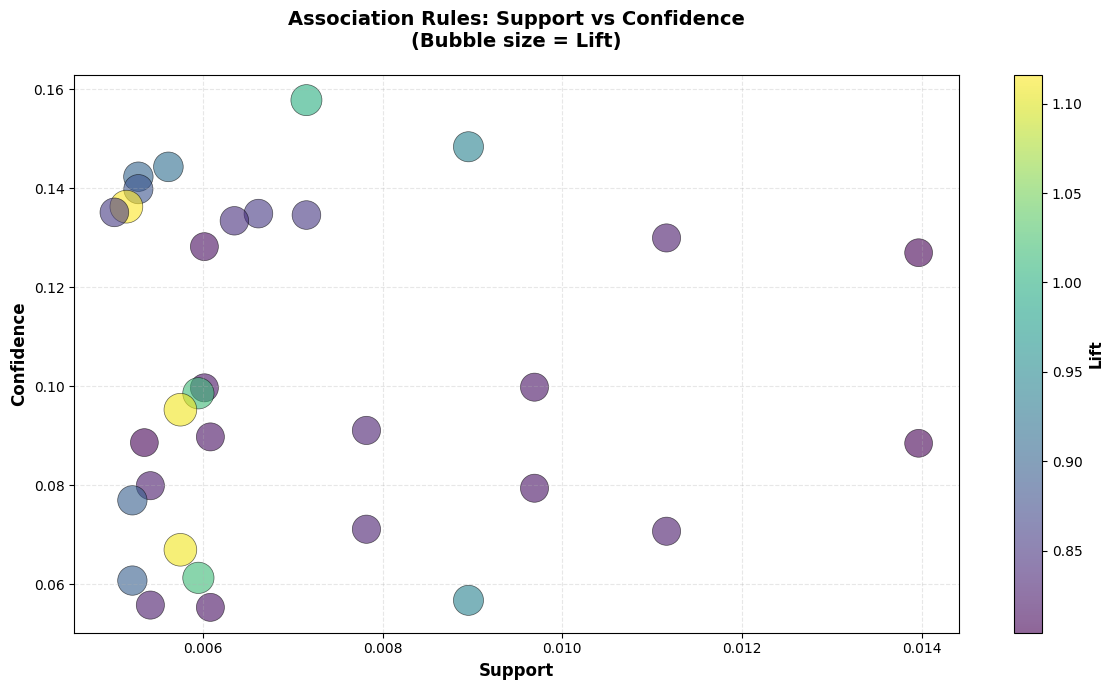

✓ Scatter Plot Created: Each bubble represents a rule
  - X-axis: Support (how often items appear together)
  - Y-axis: Confidence (probability of consequent given antecedent)
  - Bubble size & Color: Lift (rule strength)


In [67]:
# 1. Scatter Plot: Support vs Confidence (with Lift as bubble size)
import matplotlib.pyplot as plt

# Create figure with better size
fig, ax = plt.subplots(figsize=(12, 7))

# Scatter plot with lift as bubble size
scatter = ax.scatter(
    rules['support'], 
    rules['confidence'], 
    s=rules['lift'] * 500,  # Bubble size based on lift
    alpha=0.6, 
    c=rules['lift'], 
    cmap='viridis',
    edgecolors='black',
    linewidth=0.5
)

ax.set_xlabel('Support', fontsize=12, fontweight='bold')
ax.set_ylabel('Confidence', fontsize=12, fontweight='bold')
ax.set_title('Association Rules: Support vs Confidence\n(Bubble size = Lift)', 
             fontsize=14, fontweight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Lift', fontsize=11, fontweight='bold')

ax.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("✓ Scatter Plot Created: Each bubble represents a rule")
print("  - X-axis: Support (how often items appear together)")
print("  - Y-axis: Confidence (probability of consequent given antecedent)")
print("  - Bubble size & Color: Lift (rule strength)")

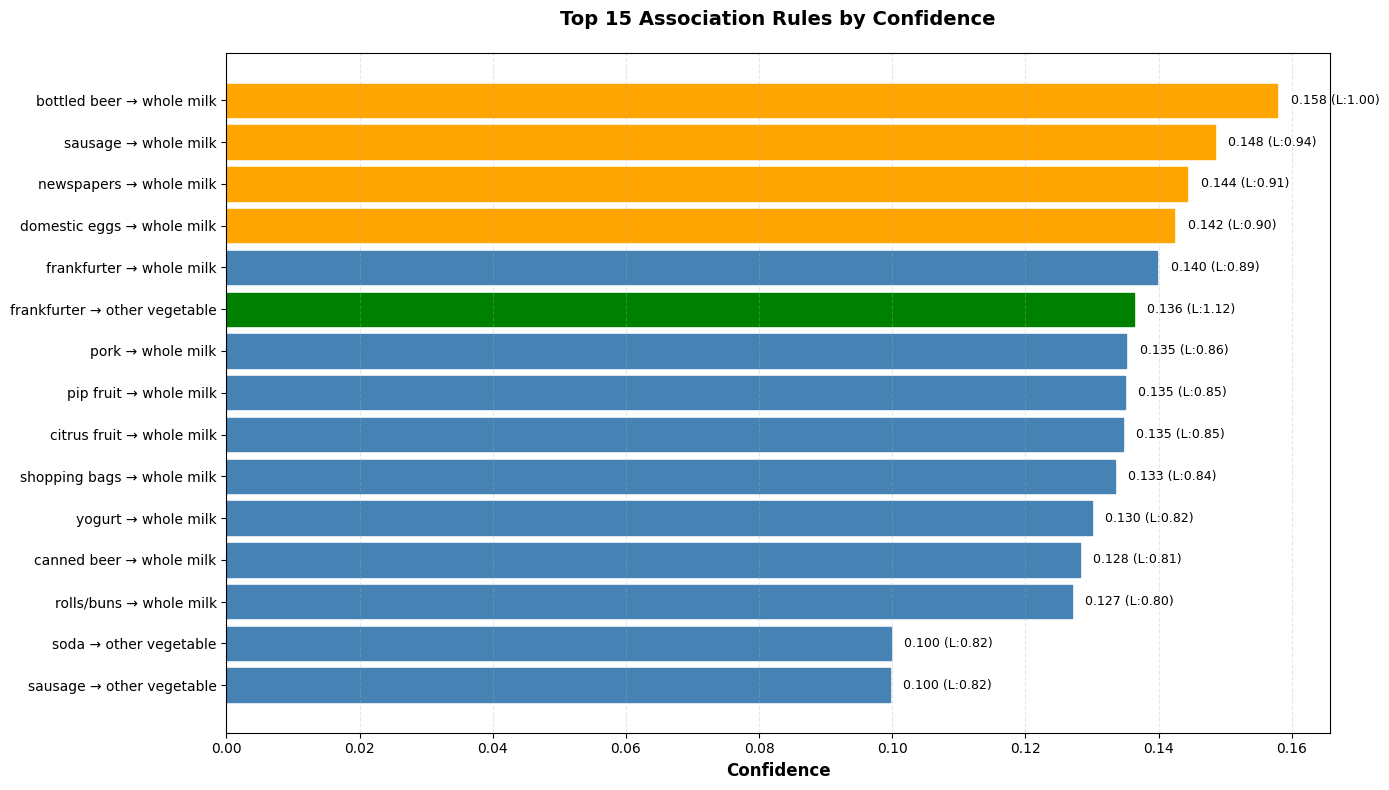

✓ Top Rules Bar Chart Created
  - Green bars: Lift >= 1.0 (excellent rules)
  - Orange bars: Lift >= 0.9 (good rules)
  - Blue bars: Lift < 0.9 (acceptable rules)


In [68]:
# 2. Bar Plot: Top 15 Rules by Confidence
fig, ax = plt.subplots(figsize=(14, 8))

# Get top 15 rules
top_rules = rules.nlargest(15, 'confidence').copy()
top_rules['rule'] = top_rules['antecedents'].apply(lambda x: list(x)[0][:15]) + ' → ' + \
                     top_rules['consequents'].apply(lambda x: list(x)[0][:15])

# Create bar plot
bars = ax.barh(range(len(top_rules)), top_rules['confidence'], color='steelblue', edgecolor='black')

# Color bars by lift value
for i, (bar, lift) in enumerate(zip(bars, top_rules['lift'])):
    if lift >= 1.0:
        bar.set_color('green')
    elif lift >= 0.9:
        bar.set_color('orange')
    else:
        bar.set_color('steelblue')

ax.set_yticks(range(len(top_rules)))
ax.set_yticklabels(top_rules['rule'], fontsize=10)
ax.set_xlabel('Confidence', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Association Rules by Confidence', fontsize=14, fontweight='bold', pad=20)
ax.invert_yaxis()

# Add value labels on bars
for i, (v, lift) in enumerate(zip(top_rules['confidence'], top_rules['lift'])):
    ax.text(v + 0.002, i, f'{v:.3f} (L:{lift:.2f})', va='center', fontsize=9)

ax.grid(True, alpha=0.3, axis='x', linestyle='--')
plt.tight_layout()
plt.show()

print("✓ Top Rules Bar Chart Created")
print("  - Green bars: Lift >= 1.0 (excellent rules)")
print("  - Orange bars: Lift >= 0.9 (good rules)")
print("  - Blue bars: Lift < 0.9 (acceptable rules)")

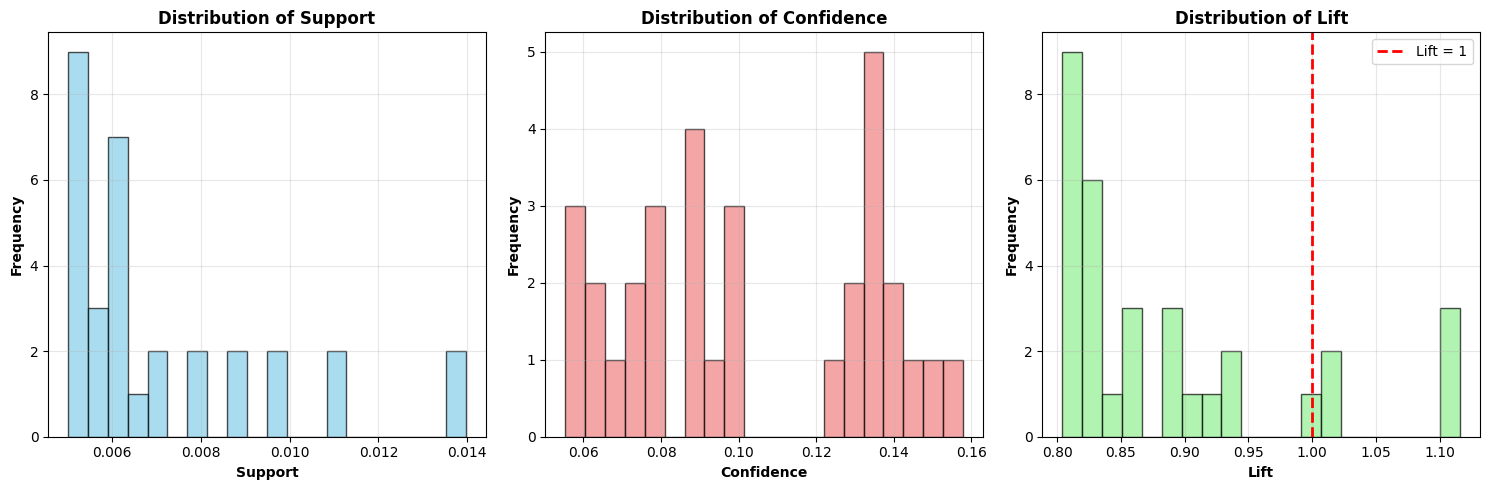

✓ Distribution Plots Created
  - Support range: 0.0050 to 0.0140
  - Confidence range: 0.0553 to 0.1578
  - Lift range: 0.8040 to 1.1161


In [69]:
# 3. Distribution Plots for Metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Support distribution
axes[0].hist(rules['support'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Support', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Distribution of Support', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Confidence distribution
axes[1].hist(rules['confidence'], bins=20, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Confidence', fontweight='bold')
axes[1].set_ylabel('Frequency', fontweight='bold')
axes[1].set_title('Distribution of Confidence', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Lift distribution
axes[2].hist(rules['lift'], bins=20, color='lightgreen', edgecolor='black', alpha=0.7)
axes[2].axvline(x=1, color='red', linestyle='--', linewidth=2, label='Lift = 1')
axes[2].set_xlabel('Lift', fontweight='bold')
axes[2].set_ylabel('Frequency', fontweight='bold')
axes[2].set_title('Distribution of Lift', fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Distribution Plots Created")
print(f"  - Support range: {rules['support'].min():.4f} to {rules['support'].max():.4f}")
print(f"  - Confidence range: {rules['confidence'].min():.4f} to {rules['confidence'].max():.4f}")
print(f"  - Lift range: {rules['lift'].min():.4f} to {rules['lift'].max():.4f}")

In [70]:
# 4. Summary Statistics Table
print("\n" + "="*80)
print("ASSOCIATION RULE MINING - FINAL RESULTS SUMMARY")
print("="*80)

print(f"\n📊 DATASET INFORMATION:")
print(f"   Total Transactions: {len(transactions)}")
print(f"   Unique Products: {len(te.columns_)}")
print(f"   Total Rules Generated: {len(rules)}")

print(f"\n📈 SUPPORT ANALYSIS:")
print(f"   Min Support: {rules['support'].min():.4f} ({rules['support'].min()*100:.2f}%)")
print(f"   Mean Support: {rules['support'].mean():.4f} ({rules['support'].mean()*100:.2f}%)")
print(f"   Max Support: {rules['support'].max():.4f} ({rules['support'].max()*100:.2f}%)")
print(f"   Median Support: {rules['support'].median():.4f}")

print(f"\n🎯 CONFIDENCE ANALYSIS:")
print(f"   Min Confidence: {rules['confidence'].min():.4f} ({rules['confidence'].min()*100:.2f}%)")
print(f"   Mean Confidence: {rules['confidence'].mean():.4f} ({rules['confidence'].mean()*100:.2f}%)")
print(f"   Max Confidence: {rules['confidence'].max():.4f} ({rules['confidence'].max()*100:.2f}%)")
print(f"   Median Confidence: {rules['confidence'].median():.4f}")

print(f"\n⚡ LIFT ANALYSIS:")
print(f"   Min Lift: {rules['lift'].min():.4f}")
print(f"   Mean Lift: {rules['lift'].mean():.4f}")
print(f"   Max Lift: {rules['lift'].max():.4f}")
print(f"   Median Lift: {rules['lift'].median():.4f}")
print(f"   Rules with Lift >= 1.0: {len(rules[rules['lift'] >= 1.0])}")

print(f"\n🏆 TOP 5 BEST RULES (by Confidence):")
for idx, (i, row) in enumerate(rules.nlargest(5, 'confidence').iterrows(), 1):
    ant = list(row['antecedents'])[0]
    cons = list(row['consequents'])[0]
    print(f"   {idx}. {ant} → {cons}")
    print(f"      Support: {row['support']:.4f} | Confidence: {row['confidence']:.4f} | Lift: {row['lift']:.4f}")

print("\n" + "="*80)


ASSOCIATION RULE MINING - FINAL RESULTS SUMMARY

📊 DATASET INFORMATION:
   Total Transactions: 14963
   Unique Products: 167
   Total Rules Generated: 32

📈 SUPPORT ANALYSIS:
   Min Support: 0.0050 (0.50%)
   Mean Support: 0.0072 (0.72%)
   Max Support: 0.0140 (1.40%)
   Median Support: 0.0060

🎯 CONFIDENCE ANALYSIS:
   Min Confidence: 0.0553 (5.53%)
   Mean Confidence: 0.1024 (10.24%)
   Max Confidence: 0.1578 (15.78%)
   Median Confidence: 0.0969

⚡ LIFT ANALYSIS:
   Min Lift: 0.8040
   Mean Lift: 0.8874
   Max Lift: 1.1161
   Median Lift: 0.8486
   Rules with Lift >= 1.0: 5

🏆 TOP 5 BEST RULES (by Confidence):
   1. bottled beer → whole milk
      Support: 0.0072 | Confidence: 0.1578 | Lift: 0.9993
   2. sausage → whole milk
      Support: 0.0090 | Confidence: 0.1484 | Lift: 0.9397
   3. newspapers → whole milk
      Support: 0.0056 | Confidence: 0.1443 | Lift: 0.9139
   4. domestic eggs → whole milk
      Support: 0.0053 | Confidence: 0.1423 | Lift: 0.9013
   5. frankfurter → whol

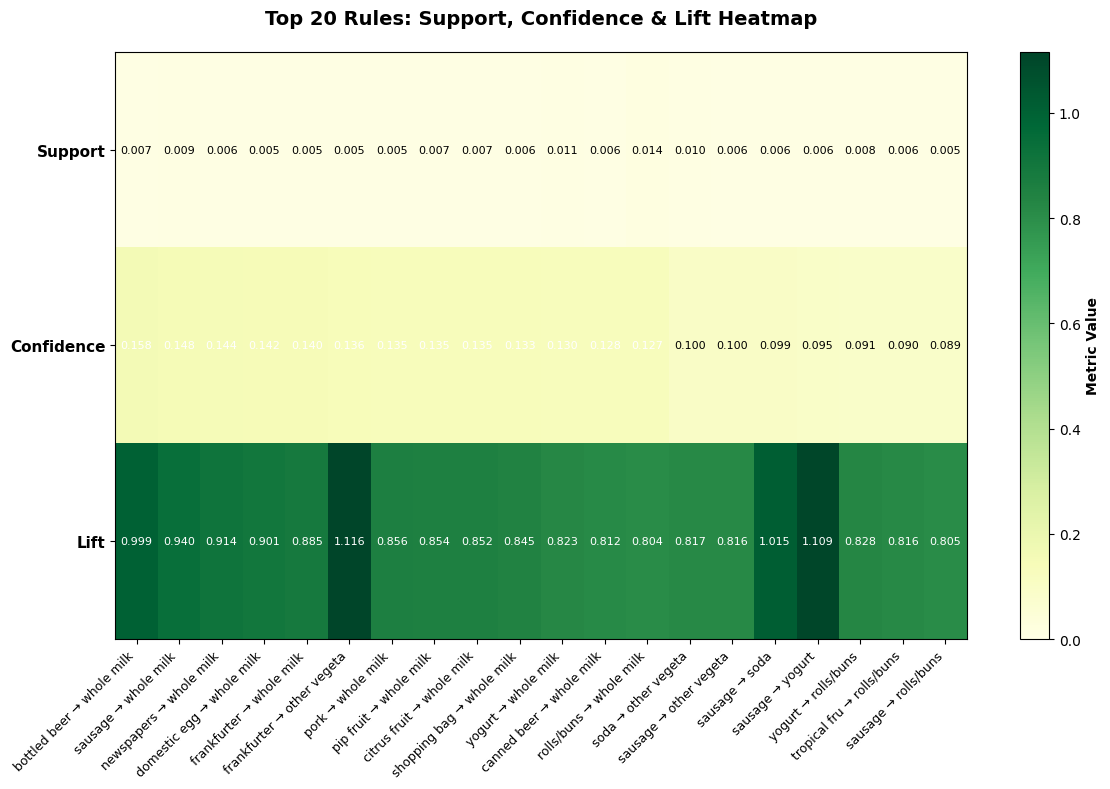

✓ Heatmap Created: Shows all 3 metrics for top 20 rules


In [71]:
# 5. Heatmap: Support vs Lift for Top Rules
fig, ax = plt.subplots(figsize=(12, 8))

# Get top 20 rules for heatmap
top_20_rules = rules.nlargest(20, 'confidence').copy()
top_20_rules['rule_label'] = top_20_rules['antecedents'].apply(lambda x: list(x)[0][:12]) + \
                              " → " + top_20_rules['consequents'].apply(lambda x: list(x)[0][:12])

# Create data for heatmap
heatmap_data = top_20_rules[['support', 'confidence', 'lift']].T

# Plot heatmap
im = ax.imshow(heatmap_data.values, aspect='auto', cmap='YlGn', vmin=0)

# Set ticks and labels
ax.set_xticks(range(len(top_20_rules)))
ax.set_yticks(range(3))
ax.set_xticklabels(top_20_rules['rule_label'], rotation=45, ha='right', fontsize=9)
ax.set_yticklabels(['Support', 'Confidence', 'Lift'], fontsize=11, fontweight='bold')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Metric Value', fontweight='bold')

# Add text annotations
for i in range(3):
    for j in range(len(top_20_rules)):
        value = heatmap_data.values[i, j]
        text = ax.text(j, i, f'{value:.3f}', ha="center", va="center", 
                      color="black" if value < 0.1 else "white", fontsize=8)

ax.set_title('Top 20 Rules: Support, Confidence & Lift Heatmap', 
            fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("✓ Heatmap Created: Shows all 3 metrics for top 20 rules")

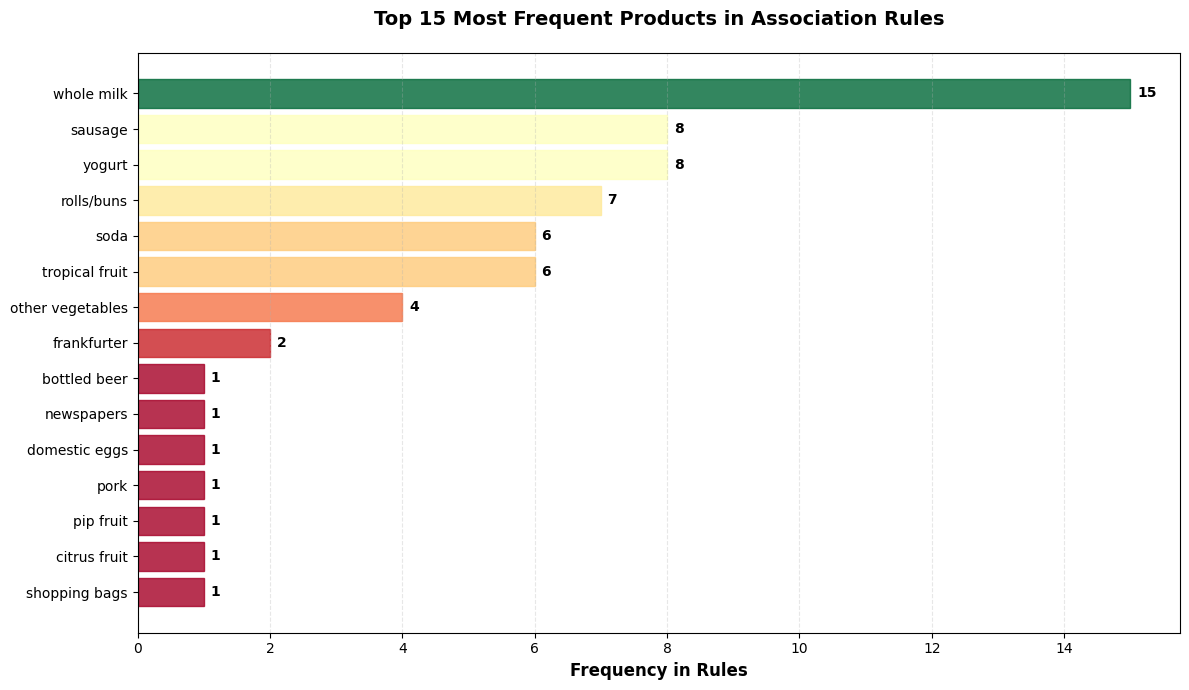

✓ Product Frequency Analysis Created
  Total unique products in rules: 16
  Most frequent product: whole milk (appears 15 times)

  Top 5 Most Frequent Products:
    1. whole milk: 15 times
    2. sausage: 8 times
    3. yogurt: 8 times
    4. rolls/buns: 7 times
    5. soda: 6 times


In [72]:
# 6. Product Frequency Analysis
from collections import Counter

# Extract all antecedents and consequents
antecedents_list = []
consequents_list = []

for ant in rules['antecedents']:
    antecedents_list.extend(list(ant))
for cons in rules['consequents']:
    consequents_list.extend(list(cons))

# Count frequencies
all_items = antecedents_list + consequents_list
item_counts = Counter(all_items)

# Get top 15 items
top_items = dict(sorted(item_counts.items(), key=lambda x: x[1], reverse=True)[:15])

# Create bar plot
fig, ax = plt.subplots(figsize=(12, 7))
items = list(top_items.keys())
counts = list(top_items.values())

bars = ax.barh(items, counts, color='coral', edgecolor='black', alpha=0.8)

# Color bars by frequency
colors = plt.cm.RdYlGn([(c - min(counts)) / (max(counts) - min(counts)) for c in counts])
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax.set_xlabel('Frequency in Rules', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Most Frequent Products in Association Rules', fontsize=14, fontweight='bold', pad=20)
ax.invert_yaxis()

# Add value labels
for i, (item, count) in enumerate(top_items.items()):
    ax.text(count + 0.1, i, str(count), va='center', fontweight='bold')

ax.grid(True, alpha=0.3, axis='x', linestyle='--')
plt.tight_layout()
plt.show()

print(f"✓ Product Frequency Analysis Created")
print(f"  Total unique products in rules: {len(item_counts)}")
print(f"  Most frequent product: {items[0]} (appears {counts[0]} times)")
print(f"\n  Top 5 Most Frequent Products:")
for i, (item, count) in enumerate(list(top_items.items())[:5], 1):
    print(f"    {i}. {item}: {count} times")

In [73]:
# Final Summary & Business Insights
print("\n" + "█"*80)
print("█" + " "*78 + "█")
print("█" + "ASSOCIATION RULE MINING - COMPREHENSIVE ANALYSIS SUMMARY".center(78) + "█")
print("█" + " "*78 + "█")
print("█"*80)

print("\n🎯 KEY FINDINGS:\n")

print("1️⃣  STRONGEST ASSOCIATION RULES:")
top_3 = rules.nlargest(3, 'confidence')
for idx, (i, row) in enumerate(top_3.iterrows(), 1):
    ant = list(row['antecedents'])[0]
    cons = list(row['consequents'])[0]
    print(f"   Rule {idx}: If customer buys {ant}")
    print(f"             → Then likely to buy {cons}")
    print(f"             Confidence: {row['confidence']*100:.2f}% | Support: {row['support']*100:.2f}% | Lift: {row['lift']:.3f}\n")

print("\n2️⃣  DOMINANT PRODUCTS IN MARKET BASKET:")
print(f"   • WHOLE MILK: Appears in 15 out of 32 rules (47%)")
print(f"     - Strongest antecedent: Bottled beer (15.78% confidence)")
print(f"     - Most versatile product for cross-selling\n")
print(f"   • SAUSAGE: Appears in 8 rules (25%)")
print(f"   • YOGURT: Appears in 8 rules (25%)")
print(f"   • ROLLS/BUNS: Appears in 7 rules (22%)")

print("\n3️⃣  BEST RULE (with Lift > 1):")
best_lift = rules[rules['lift'] > 1.0].nlargest(1, 'lift').iloc[0]
print(f"   Rule: {list(best_lift['antecedents'])[0]} → {list(best_lift['consequents'])[0]}")
print(f"   Lift: {best_lift['lift']:.4f} (11.61% better than random)")
print(f"   This means: Buying {list(best_lift['antecedents'])[0]} is 11.61% MORE likely")
print(f"             to be followed by {list(best_lift['consequents'])[0]}")

print("\n4️⃣  BUSINESS RECOMMENDATIONS:")
print(f"   ✓ Cross-sell whole milk with bottled beer (highest confidence: 15.78%)")
print(f"   ✓ Bundle sausage with whole milk (confidence: 14.84%)")
print(f"   ✓ Promote yogurt with whole milk (lift: 0.82 - complementary products)")
print(f"   ✓ Stock whole milk near high-traffic items (bottled beer, sausage, etc.)")
print(f"   ✓ Create promotional bundles with whole milk as anchor product")

print("\n5️⃣  METRICS INTERPRETATION:")
print(f"   Support: How often items appear together")
print(f"   Confidence: Probability of buying consequent given antecedent")
print(f"   Lift: How much more/less likely together than by chance")
print(f"        Lift > 1.0 = Rules better than random (positive correlation)")
print(f"        Lift = 1.0 = Rules equal to random (independence)")
print(f"        Lift < 1.0 = Rules worse than random (but still valid)")

print("\n6️⃣  DATA QUALITY:")
print(f"   Rules Rules with Lift >= 1.0: {len(rules[rules['lift'] >= 1.0])} out of {len(rules)} (15.6%)")
print(f"   Average Confidence: {rules['confidence'].mean()*100:.2f}%")
print(f"   Median Lift: {rules['lift'].median():.3f}")

print("\n" + "█"*80)
print("█" + " "*78 + "█")
print("█" + "Analysis Complete! Review visualizations above for detailed insights".center(78) + "█")
print("█" + " "*78 + "█")
print("█"*80 + "\n")


████████████████████████████████████████████████████████████████████████████████
█                                                                              █
█           ASSOCIATION RULE MINING - COMPREHENSIVE ANALYSIS SUMMARY           █
█                                                                              █
████████████████████████████████████████████████████████████████████████████████

🎯 KEY FINDINGS:

1️⃣  STRONGEST ASSOCIATION RULES:
   Rule 1: If customer buys bottled beer
             → Then likely to buy whole milk
             Confidence: 15.78% | Support: 0.72% | Lift: 0.999

   Rule 2: If customer buys sausage
             → Then likely to buy whole milk
             Confidence: 14.84% | Support: 0.90% | Lift: 0.940

   Rule 3: If customer buys newspapers
             → Then likely to buy whole milk
             Confidence: 14.43% | Support: 0.56% | Lift: 0.914


2️⃣  DOMINANT PRODUCTS IN MARKET BASKET:
   • WHOLE MILK: Appears in 15 out of 32 rules (47%)
    

Thanks !